In the previous two notebooks, I aggregated data into xarray [datasets](http://xarray.pydata.org/en/stable/data-structures.html#dataset). Here, I load the anomalies dataset to create a 3-panel figures of global geographic anomaly distribution maps for aqua chl anomaly, aqua sst anomaly and aqua chl/sst sign relationship

In [1]:
import pathlib
import os

import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.ticker as mtick
from matplotlib import rcParams
from cmocean import cm 
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.geoaxes import GeoAxes
from IPython.core.display import HTML, display

In [2]:
% matplotlib inline
display(HTML("<style>.container {width: 90%!important}</style>"))

In [3]:
# Global graphic settings
rcParams['figure.titlesize'] = 20
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['ytick.minor.visible']=True

In [4]:
def set_ticks(ax, lat_ticks, lon_ticks, transform):
    if lon_ticks:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.xaxis.set_minor_locator(mtick.FixedLocator(range(-180, 181, 10)))
        ax.set_xticks(lon_ticks, minor=True, crs=transform)
    ax.set_yticks(lat_ticks, crs=transform)
    ax.yaxis.set_minor_locator(mtick.FixedLocator(range(-90, 90, 10)))
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    return None

def set_map(ax, transform, set_xticks):    
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.LAND, facecolor='gray')
    ax.add_feature(cf.OCEAN, zorder=0, facecolor='k')
    if set_xticks:
        lon_ticks = range(0, 361, 60)
    else:
        lon_ticks = None
    lat_ticks = range(-60, 61, 60) 
    isot=dict(north=df_north, south=df_south)
    plot_isotherm(ax, isot['north'], transform=transform)
    plot_isotherm(ax, isot['south'], transform=transform)
    set_ticks(ax, lat_ticks, lon_ticks, transform=transform)
    return None

def map_anom(ax, data_array, **kwargs):
    vmin = kwargs.pop('vmin', data_array.min())
    vmax = kwargs.pop('vmax', data_array.max())
    step = kwargs.pop('step', 10)
    cb_lbl = kwargs.pop('cb_lbl', r'$mg\ m^{-3}$')
    cmap = kwargs.pop('cmap', cm.balance)
    add_cbar = kwargs.pop('add_cbar', True)
    set_xticks = kwargs.pop('set_xticks', True)
    cb_payload = kwargs.pop('cb_payload', {'orientation': 'vertical',
                                           'fraction': 0.03, 'pad': -0.005,
                                           'label': cb_lbl,
                                           'extend':'neither',
                                           'aspect': 20,
                                           'shrink': 0.7}                     )
    transform = kwargs.pop('transform', ccrs.PlateCarree())
    set_map(ax, transform, set_xticks)
    artist_payload = dict(x='lon', y='lat', ax=ax, transform=transform,
                         cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=add_cbar)
    if add_cbar:
        bar_ticks = mtick.FixedLocator(np.arange(vmin, vmax+step, step))
        cb_payload.update({'ticks': bar_ticks,})
        artist_payload.update(dict(cbar_kwargs=cb_payload))
    
    artist = data_array.plot.pcolormesh(**artist_payload)
    ax.set_xlabel('')
    ax.set_ylabel('')
    return artist


def format_cbar_ticks(quadmesh, ax, ticks=None,
                      tick_labels=['Chl- SST-', 'Chl- SST+', 'Chl+ SST-', 'Chl+ SST+'],
                     **kwargs):
    cax = pl.colorbar(mappable=quadmesh, ax=ax, fraction=0.02, pad=0.01)
    if ticks is None:
        cax.set_ticks(np.arange(len(tick_labels)))
    else:
        cax.set_ticks(ticks)
    if tick_labels:
        cax.set_ticklabels(tick_labels)
    return cax


def plot_isotherm(ax, df, transform):
    ax.plot(df.lon, df.lat, zorder=1, lw=3, color='k', transform=transform)  

In [5]:
xr_anom = xr.open_dataset('./xr_anom_2018.nc')

In [6]:
xr_anom

<xarray.Dataset>
Dimensions:                  (lat: 2160, lon: 4320, time: 9)
Coordinates:
  * time                     (time) datetime64[ns] 2018-01-01 2018-02-01 ...
  * lat                      (lat) float32 89.958336 89.875 89.79167 ...
  * lon                      (lon) float32 -179.95833 -179.875 -179.79166 ...
Data variables:
    aqua_chl_anom            (time, lat, lon) float64 ...
    viirs_chl_anom           (time, lat, lon) float64 ...
    aqua_sst_anom            (time, lat, lon) float64 ...
    time_avg_aqua_chl_anom   (lat, lon) float64 ...
    time_avg_viirs_chl_anom  (lat, lon) float64 ...
    time_avg_sst_anom        (lat, lon) float64 ...
    aqua_chl_sst_anom_sign   (lat, lon) float64 ...
    viirs_chl_sst_anom_sign  (lat, lon) float64 ...

In [7]:
df_south = pd.read_csv('../sst_iso_south.txt', delim_whitespace=True,
                       names=['lon', 'lat'])
df_north = pd.read_csv('../sst_iso_north.txt', delim_whitespace=True,
                      names=['lon', 'lat'])

In [8]:
df_south.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3378 entries, 0 to 3377
Data columns (total 2 columns):
lon    3378 non-null float64
lat    3378 non-null float64
dtypes: float64(2)
memory usage: 52.9 KB


In [9]:
df_north.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 2 columns):
lon    2218 non-null float64
lat    2218 non-null float64
dtypes: float64(2)
memory usage: 34.7 KB


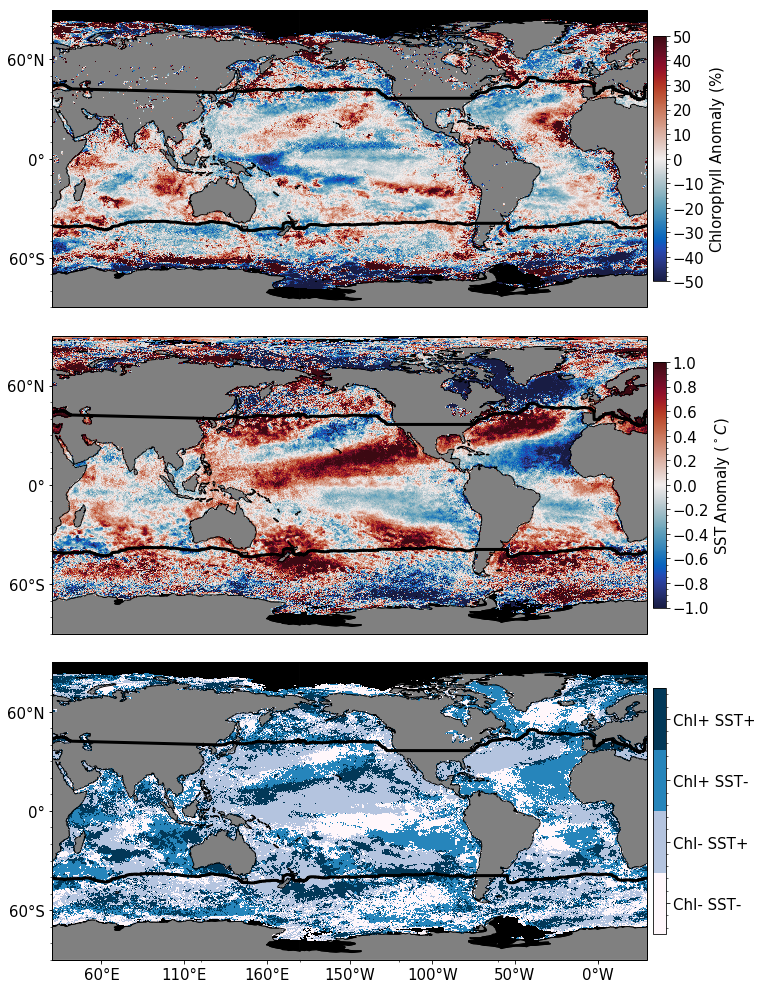

In [10]:
central_long = -150
tran = ccrs.PlateCarree(central_longitude=central_long)
lat = xr_anom.lat
lon = xr_anom.lon
chl_anom = xr_anom.time_avg_aqua_chl_anom
sst_anom = xr_anom.time_avg_sst_anom
anom_sign = xr_anom.aqua_chl_sst_anom_sign
f_chl, axs = pl.subplots(nrows=3, figsize=(11, 18),
                         subplot_kw={'projection': tran})

f_chl.subplots_adjust(hspace=0)
qmesh_0 = map_anom(axs[0], chl_anom, vmin=-50, vmax=50, cb_lbl=r'Chlorophyll Anomaly ($\%$)',
                  set_xticks=False, add_cbar=False)
cax = format_cbar_ticks(qmesh_0, ax=axs[0], ticks=range(-50, 51, 10), tick_labels=None)
cax.set_label(r'Chlorophyll Anomaly ($\%$)')
qmesh_1 = map_anom(axs[1], sst_anom, vmin=-1, vmax=1, step=0.2, cb_lbl=r'SST Anomaly ($^\circ C$)',
                  set_xticks=False, add_cbar=False)
cax = format_cbar_ticks(qmesh_1, ax=axs[1], ticks=np.arange(-1, 1.2, 0.2), tick_labels=None)
cax.set_label(r'SST Anomaly ($^\circ C$)')
qmesh_2 = map_anom(axs[2], anom_sign, vmin=-.5, vmax=3.5, step=1, cmap=pl.cm.get_cmap('PuBu', 4), add_cbar=False)
cax = format_cbar_ticks(quadmesh=qmesh_2, ax=axs[2])

In [11]:
f_chl.savefig('../FigJar/three_panels.png', dpi=300)